In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
import numpy as np
import torchvision
import matplotlib.pyplot as plt
import time
import os
import copy
import math
from pathlib import Path
from tqdm.notebook import trange, tqdm
from itertools import islice
from collections import Counter
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torchvision import datasets, models, transforms
import itertools


print(torch.__version__)
plt.ion()   # interactive mode
torch.cuda.is_available()

1.0.0


True

In [3]:
try:
    from google.colab import drive
    drive.mount('/content/gdrive')
    LABS_DIR = Path ('/content/gdrive/My Drive/Labs')
except:
    LABS_DIR = Path ('E:/Labs/')

DATA_DIR = LABS_DIR/'Data'    

In [4]:
# Data augmentation and normalization for training
# for validatin we use normalization and resize (for train we also change the angle and size of the images)
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomRotation(5),
        transforms.RandomHorizontalFlip(),
        transforms.RandomResizedCrop(224, scale=(0.96, 1.0), ratio=(0.95, 1.05)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize([224,224]),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize([224,224]),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
}

In [5]:
''' The function takes the data loader and a parameter  '''
def create_train_val_slice(data,train_limit=None,val_same_as_train=False, val_limit=None):
    train1, train2 = itertools.tee(islice(data['train'],train_limit))
    result_slice = {}
    result_slice['train'] = train1
    if val_same_as_train:
        result_slice['val'] = train2
    else:
        result_slice['val'] = islice(data['val'],val_limit)
    return result_slice

image_datasets = {x: datasets.ImageFolder(os.path.join(DATA_DIR, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                              shuffle=True, num_workers=4)
              for x in ['train', 'val']}

dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Classes: ", class_names) 
print(f'Train image size: {dataset_sizes["train"]}')
print(f'Validation image size: {dataset_sizes["val"]}')

Classes:  ['Angry', 'Disgust', 'Fear', 'Happy', 'Neutral', 'Sad', 'Surprise']
Train image size: 20099
Validation image size: 5742


classes=tensor([0, 3, 0, 5])


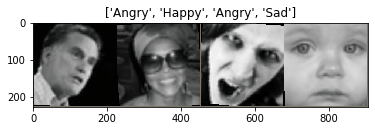

In [6]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated
# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))
# Make a grid from batch
sample_train_images = torchvision.utils.make_grid(inputs)
#imshow(sample_train_images, title=classes)
print(f"classes={classes}")
imshow(sample_train_images, title=[class_names[i] for i in classes])


In [7]:
# # Testing frequencies on a subset of the training samples
# test_freq_limit = 2 # Use None for all
# all_labels = []
# #dataloader_train_slice = islice(dataloaders['train'],test_freq_limit)
# print("Creating slice")
# slc = create_train_val_slice(dataloaders,train_limit=10,val_same_as_train=False, val_limit=20)
# print("Checking slice")
# for i, (inputs, labels) in enumerate(slc['train']):
#     all_labels.extend(labels.tolist())
# print("Total label:frequencies are:", Counter(all_labels))

# all_labels = []
# for i, (inputs, labels) in enumerate(slc['val']):
#     all_labels.extend(labels.tolist())

# print("Total label:frequencies are:", Counter(all_labels))

In [8]:
def train_model(data, model, criterion, optimizer, scheduler, num_epochs=2, checkpoint = None):
    since = time.time()

    if checkpoint is None:
        best_model_wts = copy.deepcopy(model.state_dict())
        best_loss = math.inf
        best_acc = 0.
    else:
        print('Val loss: {}, Val accuracy: {}'\
              .format(checkpoint["best_val_loss"], checkpoint["best_val_accuracy"]))
        model.load_state_dict(checkpoint['model_state_dict'])
        best_model_wts = copy.deepcopy(model.state_dict())
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        scheduler.load_state_dict(checkpoint['scheduler_state_dict'])
        best_loss = checkpoint['best_val_loss']
        best_acc = checkpoint['best_val_accuracy']

    print("Starting epochs")
    outer = tqdm(total=num_epochs, desc='Epoch', position=0)
    inner = tqdm(total=500, position=1)
    for epoch in range(num_epochs):
        outer.update(1)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
                scheduler.step()
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            total = 500

            # Handle tqdm inner loop counter
            inner.total = total
            inner.reset()
            inner_total = 0 
            
            # Iterate over data.
            for i, (inputs, labels) in enumerate(data[phase]):
                
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()
                
                if i>0:
                    report_str = '[%d, %d] loss: %.3f' % (epoch + 1, i, running_loss / i * inputs.size(0))
                else:
                    report_str = "first iteration"

                # Update inner tqdm, we are about to override the previous maximum, update maximum
                if inner_total >= total:
                    total = total *2
                    inner.total = total
                inner_total = inner_total + 1
                inner.update(1) # Advance the tqdm counter
                inner.desc = f'Phase: {phase} ' + report_str

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            loss_str = f'Epoch: {epoch}, {phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}'
            inner.write(loss_str)
            

            # deep copy the model
            if phase == 'val' and epoch_loss < best_loss:
                print('New best model found!')
                print('New record loss:{}, previous record loss: {}'.format(epoch_loss, best_loss))
                best_loss = epoch_loss
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
                #save the weights
                torch.save(best_model_wts, CHECK_POINT_PATH)
        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:.4f} Best val loss: {:.4f}'.format(best_acc, best_loss))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, best_loss, best_acc

In [9]:
model_conv = torchvision.models.resnet18(pretrained=True)

# Train Model

In [10]:
# Parameters of newly constructed modules have requires_grad=True by default

ct = 0
for child in model_conv.children():
  ct += 1
  # freezes layers 1-6 in the total 10 layers of Resnet50
  if ct < 7:
    for param in child.parameters():
      param.requires_grad = False


num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, len(class_names))
model_conv = model_conv.to(device)
criterion = nn.CrossEntropyLoss()
# Observe that only parameters of final layer are being optimized
optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)
# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

In [11]:
CHECK_POINT_PATH = LABS_DIR/'ModelParams'/'checkpoint.tar'

try:
    checkpoint = torch.load(CHECK_POINT_PATH)
    print("checkpoint loaded")
except:
    checkpoint = None
    print("checkpoint not found")

checkpoint loaded


In [12]:
# from tqdm.notebook import trange, tqdm
# print("Starting")
# num_epochs = 2
# outer = tqdm(total=num_epochs, desc='Epoch', position=0)
# inner = tqdm(total=500, position=1)
# for epoch in range(num_epochs):
#     #print('Epoch {}/{}'.format(epoch, num_epochs - 1))
#     outer.update(1)
#     #print('-' * 10)
    
#     for phase in ['train', 'val']:
#         #print('Phase=', phase)
#         total = 500
#         inner.desc = f'Phase: {phase}'
#         inner.total = total
#         inner.reset()
#         running_loss = 0.0
#         running_corrects = 0
#         inner_total = 0 
#         # Iterate over data.       
#         for i, (inputs, labels) in enumerate(dataloaders[phase]):
#             if inner_total >= total:
#                 total = total *2
#                 inner.total = total
#             inner_total = inner_total + 1
#             inner.update(1)
          

In [13]:
%%time
data = create_train_val_slice(dataloaders,train_limit=100,val_same_as_train=True, val_limit=20)
model_conv, best_val_loss, best_val_acc = train_model(data,
                                                      model_conv,
                                                      criterion,
                                                      optimizer_conv,
                                                      exp_lr_scheduler,
                                                      num_epochs = 10,
                                                      checkpoint = checkpoint)

Val loss: 1.4900037866774771, Val accuracy: 0.44183211424590735
Starting epochs


Epoch: 0, train Loss: 0.0292 Acc: 0.0088
Epoch: 0, val Loss: 0.0984 Acc: 0.0338
New best model found!
New record loss:0.09839439232230643, previous record loss: 1.4900037866774771



AttributeError: 'int' object has no attribute 'double'

In [14]:
torch.save({'model_state_dict': model_conv.state_dict(),
            'optimizer_state_dict': optimizer_conv.state_dict(),
            'best_val_loss': best_val_loss,
            'best_val_accuracy': best_val_acc,
            'scheduler_state_dict' : exp_lr_scheduler.state_dict(),
            }, CHECK_POINT_PATH)

NameError: name 'best_val_loss' is not defined

# Test Model

In [ ]:
model_conv.eval()